In [1]:
import numpy as np
import matplotlib.pyplot as plt
import msmtools
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

In [2]:
def coupled_matrix(eps1, eps2, lam):
    """
    assembles transition matrix of 2 coupled 2-state systems.
    :param eps1: float, 0 <= eps1 <= 1, probability of system 1 to change state
    :param eps2: float, 0 <= eps1 <= 1, probability of system 2 to change state
    :param lam: float, coupling parameter
    :return:
    np.ndarray, reversible transition probability matrix of full system
    """
    T = np.array([[(1 - eps1) * (1 - eps2) - lam, eps1 * (1 - eps2) - lam, (1 - eps1) * eps2+lam, eps1 * eps2+lam],
                 [eps1 * (1 - eps2) - lam, (1 - eps1) * (1 - eps2) - lam,  eps1  * eps2+lam,      (1 - eps1) *  eps2+lam],
                 [(1 - eps1) * eps2 + lam,  eps1 * eps2 + lam,       (1 - eps1) * (1 - eps2) - lam, eps1 * (1 - eps2) - lam],
                 [eps1  * eps2 + lam, (1 - eps1) *  eps2 + lam, eps1 * (1 - eps2) - lam, (1 - eps1) * (1 - eps2) - lam]])
    assert msmtools.analysis.is_tmatrix(T)
    assert msmtools.analysis.is_reversible(T)
    return T

In [3]:
N = int(5e5)
eps = 0.1

couplings = [0, 1e-2, 5e-2]
data_usage = np.logspace(1, len(str(N))-1, 30).astype(int)

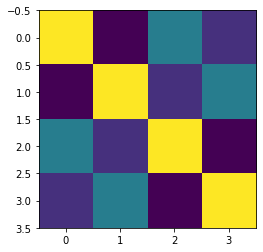

In [4]:
T = coupled_matrix(eps, eps, couplings[-1])
plt.imshow(T, norm=plt.matplotlib.colors.LogNorm())

In [5]:
ind_ts_comb = np.zeros((len(couplings), 4, 4, data_usage.shape[0]))
dep_ts_comb = np.zeros((len(couplings), 4, 4, data_usage.shape[0]))
real_mat = np.zeros((len(couplings), 4, 4))
dep_sampling = np.zeros((len(couplings), 2, 4, data_usage.shape[0]))

dep_fullyconnected = np.zeros((len(couplings), data_usage.shape[0]))
ind_fullyconnected = np.zeros((len(couplings), data_usage.shape[0]))

ind_sampling = {0:np.zeros((len(couplings), 2, data_usage.shape[0])), 
                1:np.zeros((len(couplings), 2, data_usage.shape[0]))}
ind_sampled_T = {0:np.zeros((len(couplings), 2, 2, data_usage.shape[0])), 
                1:np.zeros((len(couplings), 2, 2, data_usage.shape[0]))}

tmat_traces_dep = np.zeros((len(couplings), data_usage.shape[0]))
tmat_traces_ind = np.ones((len(couplings), data_usage.shape[0])) # is product -> ones

tmat_fronorms_dep = np.zeros((len(couplings), data_usage.shape[0]))
tmat_fronorms_ind = np.ones((len(couplings), data_usage.shape[0])) # is product -> ones

ind_its = np.zeros((len(couplings), 3, data_usage.shape[0])) + np.NaN
dep_its = np.zeros((len(couplings), 3, data_usage.shape[0])) + np.NaN

ind_pis = np.zeros((len(couplings), 4, data_usage.shape[0])) + np.NaN
dep_pis = np.zeros((len(couplings), 4, data_usage.shape[0])) + np.NaN

In [6]:
for lam_n, _lambda in tqdm(enumerate(couplings), total=len(couplings)):
    T = coupled_matrix(eps, eps, _lambda)
    real_mat[lam_n] = T
    traj_comb = msmtools.generation.generate_traj(T, N)
    traj1 = np.array([d in (0, 1) for d in traj_comb]).astype(int)
    traj2 = np.array([d in (0, 2) for d in traj_comb]).astype(int)
   
    independent_trajs = [traj1, traj2]
    
    
    for fin_n, fin in enumerate(data_usage):
        for n, t in enumerate(independent_trajs):
            c = msmtools.estimation.cmatrix(t[:fin], 1, sparse_return=False, nstates=2)

            ind_sampling[n][lam_n, 0, fin_n] = c[0, 1]
            ind_sampling[n][lam_n, 1, fin_n] = c[1, 0]

            if 0 in c.sum(axis=1):
                for n, row in enumerate(c):
                    if row.sum() == 0:
                        c[n, n] = 1

            T = msmtools.estimation.transition_matrix(c)
            ind_fullyconnected[lam_n, fin_n] += int(msmtools.analysis.is_connected(T))
            
            ind_sampled_T[n][lam_n, :, :, fin_n] = T
            
            tmat_traces_ind[lam_n, fin_n] *=  np.linalg.norm(T, ord='nuc')
            tmat_fronorms_ind[lam_n, fin_n] *=  np.linalg.norm(T, ord='fro')**2

        ind_t_comb = np.kron(ind_sampled_T[0][lam_n, :, :, fin_n], ind_sampled_T[1][lam_n, :, :, fin_n])
        ind_ts_comb[lam_n, :, :, fin_n] = ind_t_comb
        
        if msmtools.analysis.is_connected(ind_t_comb):
            ind_pis[lam_n, :, fin_n] = msmtools.analysis.statdist(ind_t_comb)
            ind_its[lam_n, :, fin_n] = msmtools.analysis.timescales(ind_t_comb)[1:]  # 0-th is infty

        c = msmtools.estimation.cmatrix(traj_comb[:fin], 1, sparse_return=False, nstates=4)
        if 0 in c.sum(axis=1):
            for n, row in enumerate(c):
                if row.sum() == 0:
                    c[n, n] = 1
        dep_t_comb = msmtools.estimation.transition_matrix(c)
        dep_ts_comb[lam_n, :, :, fin_n] = dep_t_comb
        dep_fullyconnected[lam_n, fin_n] = int(msmtools.analysis.is_connected(dep_t_comb))
        
        if msmtools.analysis.is_connected(dep_t_comb):
            dep_pis[lam_n, :, fin_n] = msmtools.analysis.statdist(dep_t_comb)
            dep_its[lam_n, :, fin_n] = msmtools.analysis.timescales(dep_t_comb)[1:]
        
        
        tmat_traces_dep[lam_n, fin_n] = np.linalg.norm(dep_ts_comb[lam_n, :, :, fin_n], ord='nuc')
        tmat_fronorms_dep[lam_n, fin_n] = np.linalg.norm(dep_ts_comb[lam_n, :, :, fin_n], ord='fro')**2
        
        
        for n in range(4):
            dep_sampling[lam_n, 0, n, fin_n] = c[:, n].sum() - c[n, n]
            dep_sampling[lam_n, 1, n, fin_n] = c[n, :].sum() - c[n, n]

/storage/mi/thempel/anaconda3/envs/py37_oct19/lib/python3.7/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/storage/mi/thempel/anaconda3/envs/py37_oct19/lib/python3.7/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


In [8]:
cmap_dep = mpl.colors.LinearSegmentedColormap.from_list("", ["grey","C0"])
cmap_ind = mpl.colors.LinearSegmentedColormap.from_list("", ["grey","C1"])
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["grey","C2"])

In [9]:
mpl.rcParams['axes.titlesize'] = 6
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['xtick.minor.pad'] = 2
mpl.rcParams['xtick.major.pad'] = 3
mpl.rcParams['ytick.minor.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 3
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['lines.markersize'] = 4

mpl.rcParams['xtick.minor.visible'] = False
mpl.rcParams['ytick.minor.visible'] = False

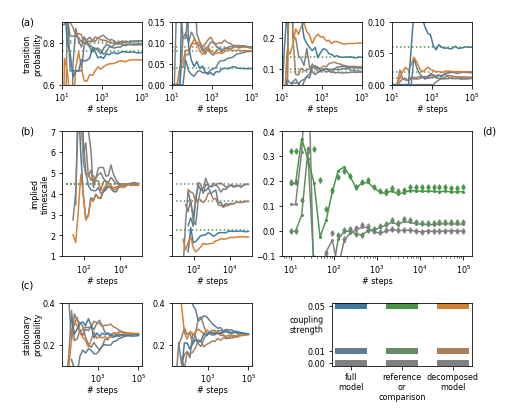

In [25]:
fig = plt.figure(figsize=(3.47*2, 2.60*2))

gw = 1000
gh = 1200
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()
ax_box.text(0.025, 0.95, '(a)', size=10)
ax_box.text(0.025, 0.66, '(b)', size=10)
ax_box.text(0.025, 0.25, '(c)', size=10)
ax_box.text(0.95, 0.66, '(d)', size=10)
lw_legend = 6
tmat_w = 220
tmat_h = 200
lmarg = 50
wspace = 60
tmarg = 50
axes_tmat = [
    fig.add_subplot(gs[tmarg:tmarg+tmat_h, lmarg + n * (tmat_w)+wspace:lmarg + (n+1) * (tmat_w)]) for n in range(4)
]


for lam_n in range(len(couplings)):
    for n in range(4):
            axes_tmat[n].semilogx(data_usage, ind_ts_comb[lam_n, n, 0], '-', c=cmap_ind(lam_n/len(couplings)), 
                                label='ind {}'.format(couplings[lam_n]) if n+lam_n == 0 else None)
            axes_tmat[n].semilogx(data_usage, dep_ts_comb[lam_n, n, 0], '-', c=cmap_dep(lam_n/len(couplings)), 
                                label='dep {}'.format(couplings[lam_n]) if n+lam_n == 0 else None, markersize=1)

            axes_tmat[n].axhline(real_mat[lam_n, n, 0], 0, 1, linestyle=':', color=cmap(lam_n/len(couplings)))
            
            axes_tmat[n].set_xlim(1e1, data_usage[-1])

hspace=150
pi_h = tmat_h * 2
axes_its = [fig.add_subplot(gs[tmarg+tmat_h+hspace:tmarg+tmat_h+hspace+pi_h, 
                            lmarg+wspace:lmarg + 1 * (tmat_w)]),
           fig.add_subplot(gs[tmarg+tmat_h+hspace:tmarg+tmat_h+hspace+pi_h, 
                            lmarg+wspace+tmat_w:lmarg + 2 * (tmat_w)])]
ax_score = fig.add_subplot(gs[tmarg+tmat_h+hspace:tmarg+tmat_h+hspace+pi_h, 
                           lmarg + 2 * tmat_w + wspace:lmarg + 4 * (tmat_w)])


for lam_n in range(len(couplings)):
    ts_real = msmtools.analysis.timescales(real_mat[lam_n], k=3)[1:]
    for _k in range(2):
        axes_its[_k].plot(data_usage, dep_its[lam_n, _k, :], '-', c=cmap_dep(lam_n/len(couplings)), 
                                    label='ind' if lam_n == 0 else None)
        axes_its[_k].plot(data_usage, ind_its[lam_n, _k, :], '-', c=cmap_ind(lam_n/len(couplings)), 
                                    label='dep' if lam_n == 0 else None)
        axes_its[_k].hlines(ts_real[_k], min(data_usage), max(data_usage), linestyle=':', color=cmap(lam_n/len(couplings)))
        axes_its[_k].semilogx()

        axes_its[_k].set_ylim(1e0, 7e0)
axes_its[1].set_yticklabels([])
        
for lam_n in range(len(couplings)):
    ax_score.plot(data_usage, tmat_traces_dep[lam_n]-tmat_traces_ind[lam_n], '.-', c=cmap(lam_n/len(couplings)))
    ax_score.plot(data_usage, tmat_fronorms_dep[lam_n]-tmat_fronorms_ind[lam_n], 'd', c=cmap(lam_n/len(couplings)))
    
ax_score.semilogx()
ax_score.set_ylim(-.1, .4)


axes_pi = [
    fig.add_subplot(gs[tmarg+tmat_h+2*hspace+pi_h:tmarg+2*tmat_h+2*hspace+pi_h, 
                       lmarg + n * (tmat_w)+wspace:lmarg + (n+1) * (tmat_w)]) for n in range(2)
]

for lam_n in range(len(couplings)):
    for n in range(2):            
        axes_pi[n].plot(data_usage, ind_pis[lam_n, n, :], '-', c=cmap_ind(lam_n/len(couplings))) 
        axes_pi[n].plot(data_usage, dep_pis[lam_n, n, :], '-', c=cmap_dep(lam_n/len(couplings))) 
        axes_pi[n].semilogx()
        axes_pi[n].set_ylim(0.1, .4)

legend_extraleftmarg = 100        
ax_legend = fig.add_subplot(gs[tmarg+tmat_h+2*hspace+pi_h:tmarg+2*tmat_h+2*hspace+pi_h, 
                       lmarg + 2 * (tmat_w)+wspace+legend_extraleftmarg:lmarg + (3+1) * (tmat_w)])

for lam_n, lam in enumerate(couplings):
    ax_legend.plot([0, 1], [lam, lam], c=cmap_dep(lam_n/len(couplings)), lw=lw_legend)
    ax_legend.plot([4, 5], [lam, lam], c=cmap_ind(lam_n/len(couplings)), lw=lw_legend)
    ax_legend.plot([2, 3], [lam, lam], c=cmap(lam_n/len(couplings)), lw=lw_legend)
ax_legend.set_yticks(couplings)
ax_legend.set_xticks([0.5, 2.5, 4.5])
ax_legend.set_xticklabels(['full\nmodel', 'reference\nor\ncomparison', 'decomposed\nmodel'])
ax_legend.set_ylabel('coupling\nstrength', rotation=True)        
axes_tmat[0].set_ylim(.6, .9)
axes_tmat[1].set_ylim(0, .15)
axes_tmat[2].set_ylim(.05, .25)
axes_tmat[3].set_ylim(0, .1)

for _ax in axes_tmat + axes_its + axes_pi + [ax_score]:
    _ax.set_xlabel('# steps')
axes_tmat[0].set_ylabel('transition\nprobability')
axes_its[0].set_ylabel('implied\ntimescale')
axes_pi[0].set_ylabel('stationary\nprobability')

fig.savefig('2state_sys.pdf')